## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

DBG = True
NO_DBG = False
CB_X = 6
CB_Y = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CB_X * CB_Y, 3), np.float32)
objp[:,:2] = np.mgrid[0 : CB_Y, 0 : CB_X].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CB_Y, CB_X), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (CB_Y, CB_X), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images

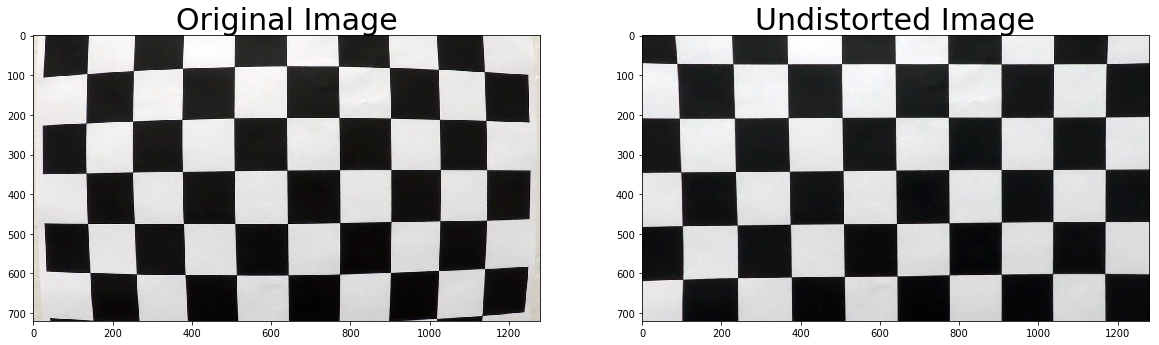

In [31]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Find camera calibration parameters given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   img_size,
                                                   None,
                                                   None)

# Helper function to undistort images
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

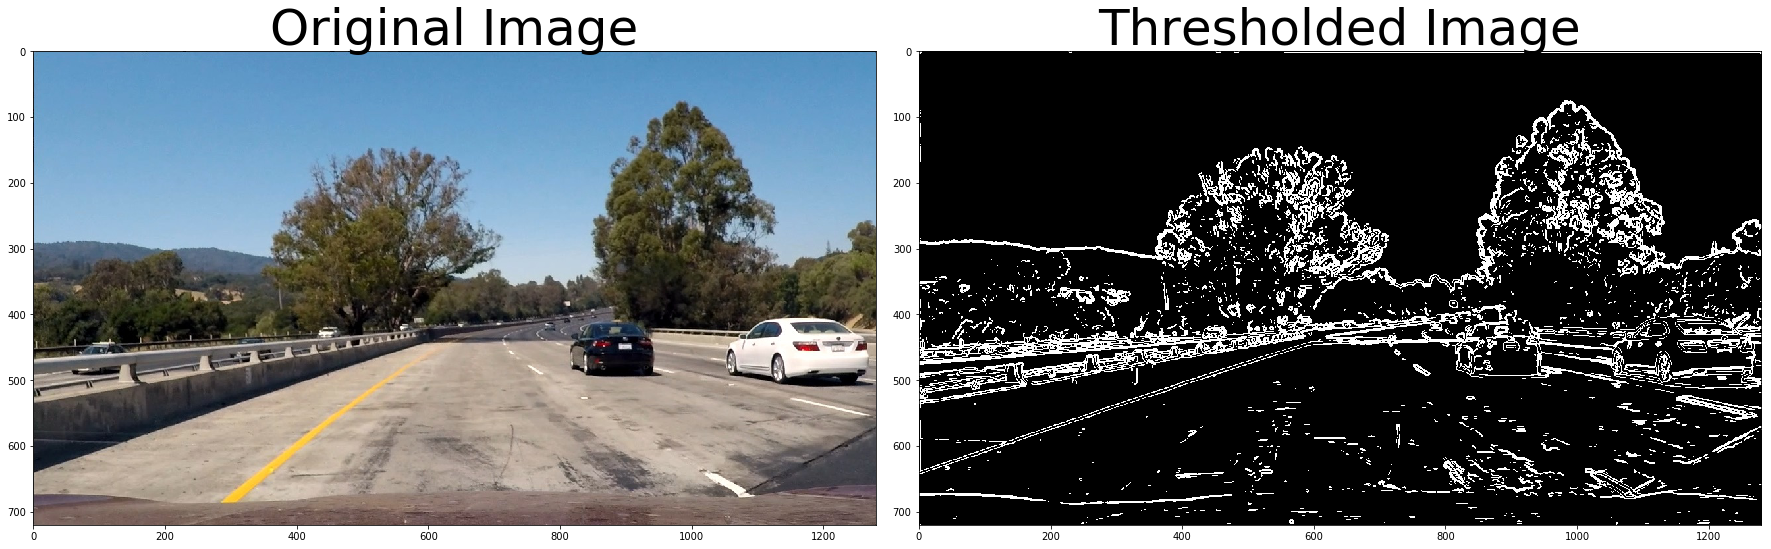

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('test_images/test1.jpg')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(dir, dtype=np.uint8)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_thresh(image, sobel_kernel=15, thresh=(0.7, 1.3)) #thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

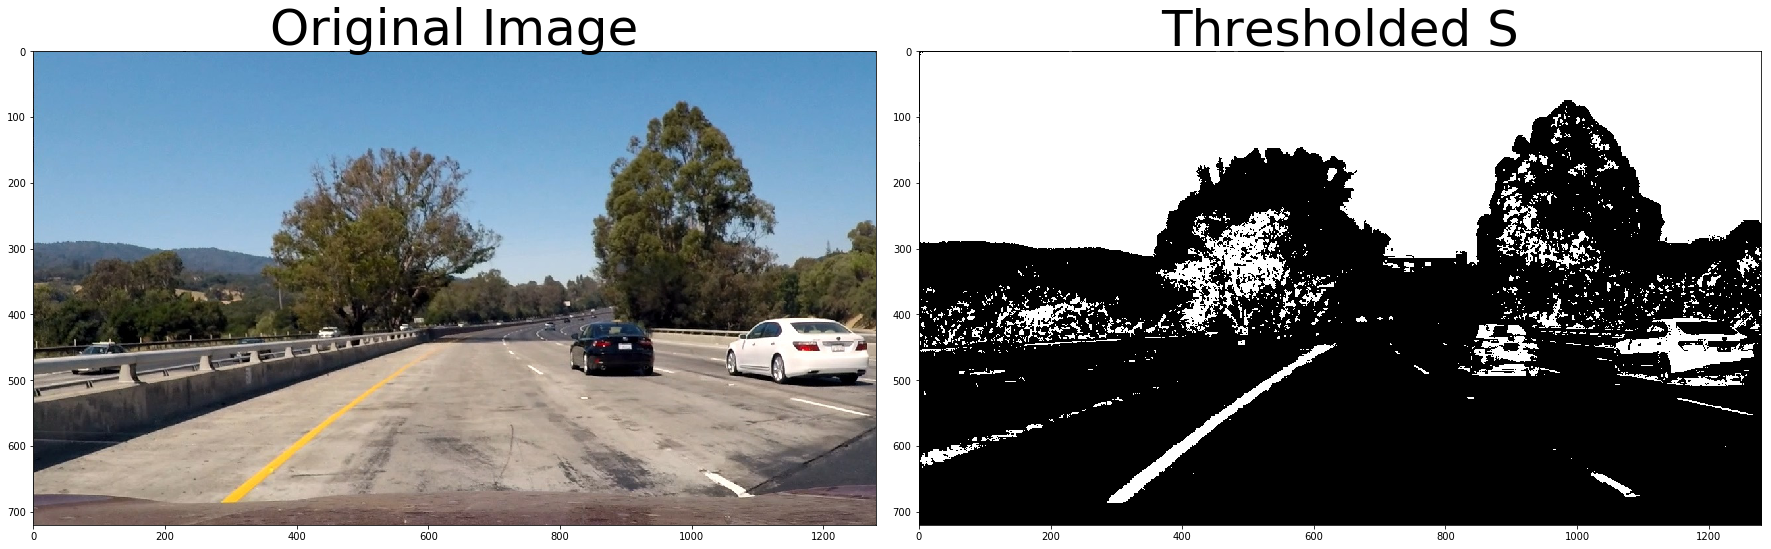

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test_images/test1.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

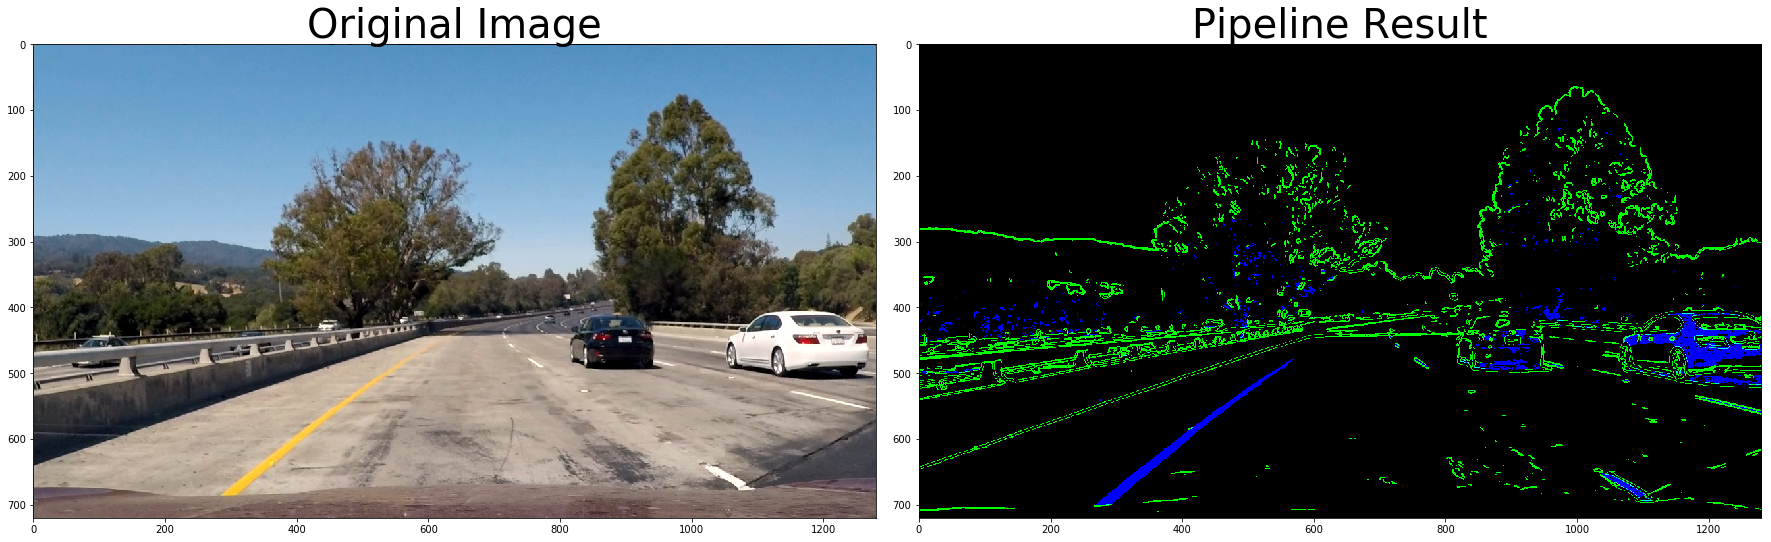

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img)

# Edit this function to create your own pipeline.
def make_binary(img, mg_thresh=(50, 100), s_thresh=(180, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Threshold color channel
    s_binary = hls_select(img, s_thresh)
    
    # Threshold sobel magnitude   
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=mg_thresh)
         
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(mag_binary), mag_binary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1) | (mag_binary == 1)] = 1
    return (combined_binary, color_binary)
    
(comb_bin, col_bin) = make_binary(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

res = col_bin
ax2.imshow(res)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view")

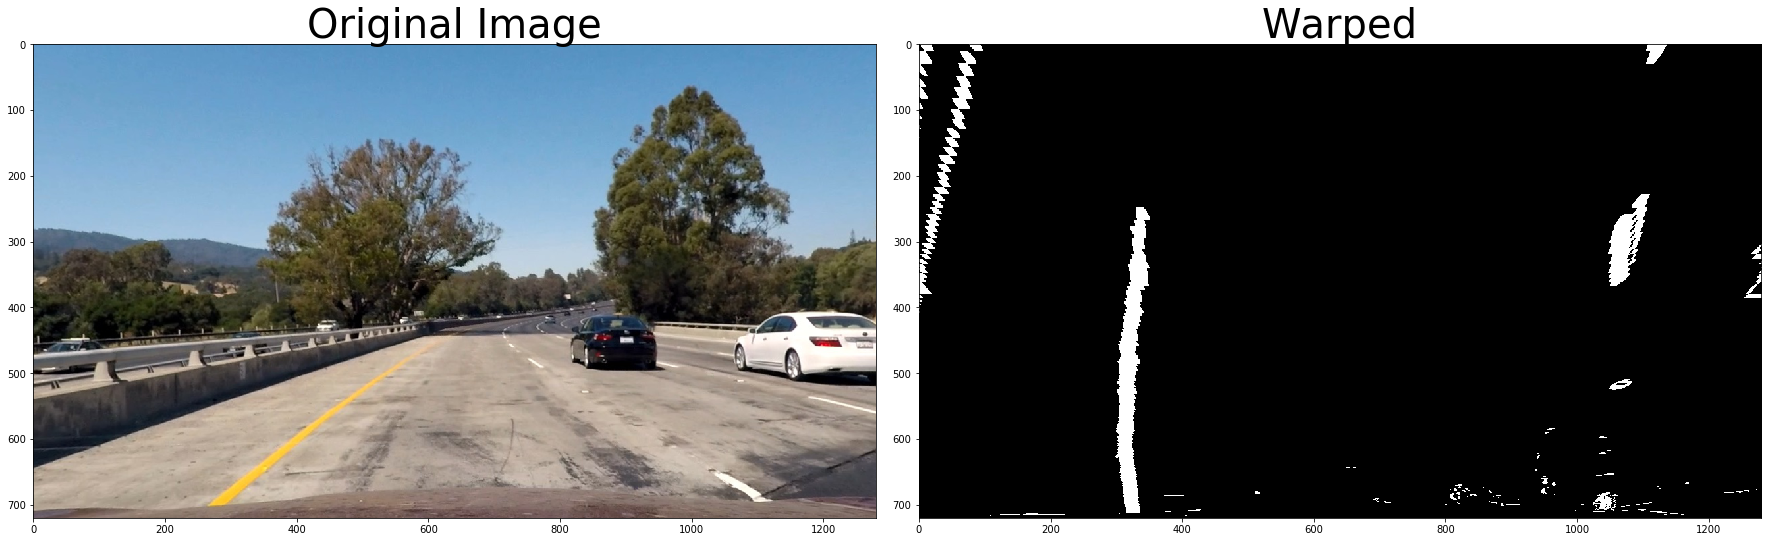

In [36]:
src_corners = [[195, img_size[1]], # left bottom
               [580, 460], # left top
               [705, 460], # right top
               [1105, img_size[1]]] # right bottom

dst_corners = [[280, img_size[1]], [280, 0], [1000, 0], [1000, img_size[1]]]

src = np.float32(src_corners)
dst = np.float32(dst_corners)
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

def perspective_transform(img, debug = False):  
    warped = cv2.warpPerspective(img,
                                 M,
                                 (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)
    
    
    if debug:
        cv2.polylines(img,
                      [np.array(src_corners,dtype=np.int32).reshape((-1, 1, 2))],
                      True,
                      (255,255,0),
                      thickness = 2)
        cv2.polylines(warped,
                      [np.array(dst_corners, dtype=np.int32).reshape((-1, 1, 2))],
                      True,
                      (255,255,0),
                      thickness=2)
    return (img, warped)

(dbg, warped) = perspective_transform(comb_bin)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist, cmap=plt.cm.gray)
ax1.set_title('Original Image', fontsize=40)

res = col_bin
ax2.imshow(warped, cmap=plt.cm.gray)
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detect lane pixels and fit to find the lane boundary.

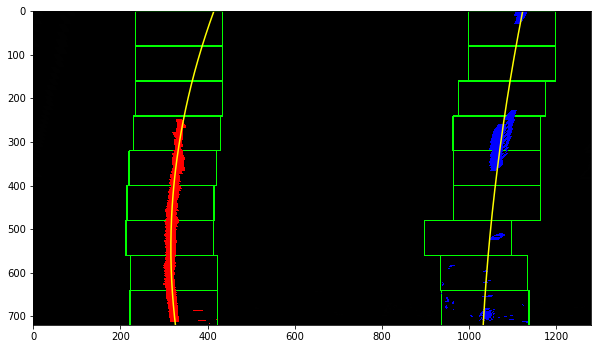

In [37]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current  - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, vis):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    if vis:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.figure(figsize=(10, 10))
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)

    return (ploty, left_fit, right_fit, left_fitx, right_fitx)


(ploty, left_fit, right_fit, left_fitx, right_fitx) = fit_polynomial(warped, True)



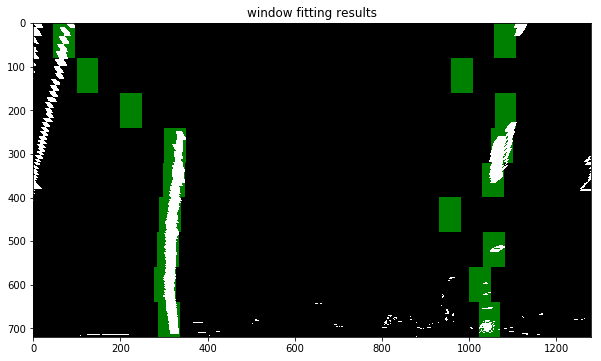

In [38]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Determine the curvature of the lane and vehicle position with respect to center.

In [39]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Do the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    pos = (img_size[0]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
    

    return left_curverad, right_curverad, pos

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, pos = measure_curvature_real(ploty, left_fitx, right_fitx)
print(left_curverad, 'm', right_curverad, 'm', pos, 'm')

490.970999167 m 1685.94815829 m -0.206369470152 m


## Warp the detected lane boundaries back onto the original image.

In [40]:
def draw_lane(undist, warped, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

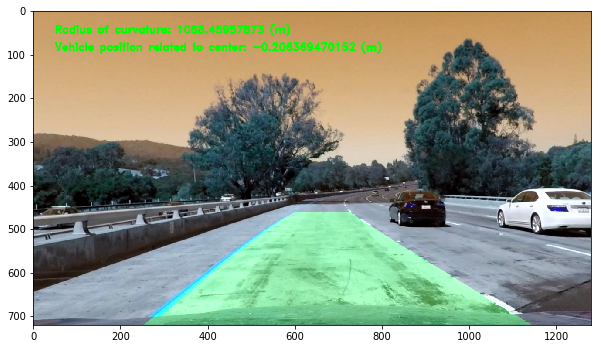

In [41]:
import cv2

def draw_text(img, curvature, relative_pos):
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,
                'Radius of curvature: ' + str(curvature) + ' (m)',
                (50, 50),
                font,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA)
    cv2.putText(img,
                'Vehicle position related to center: ' + str(relative_pos) + ' (m)' ,
                (50, 90),
                font,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA)
    return img

result = draw_lane(undist, warped, left_fitx, right_fitx, ploty)
result = draw_text(result, (left_curverad + right_curverad)/2, pos)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Pipeline

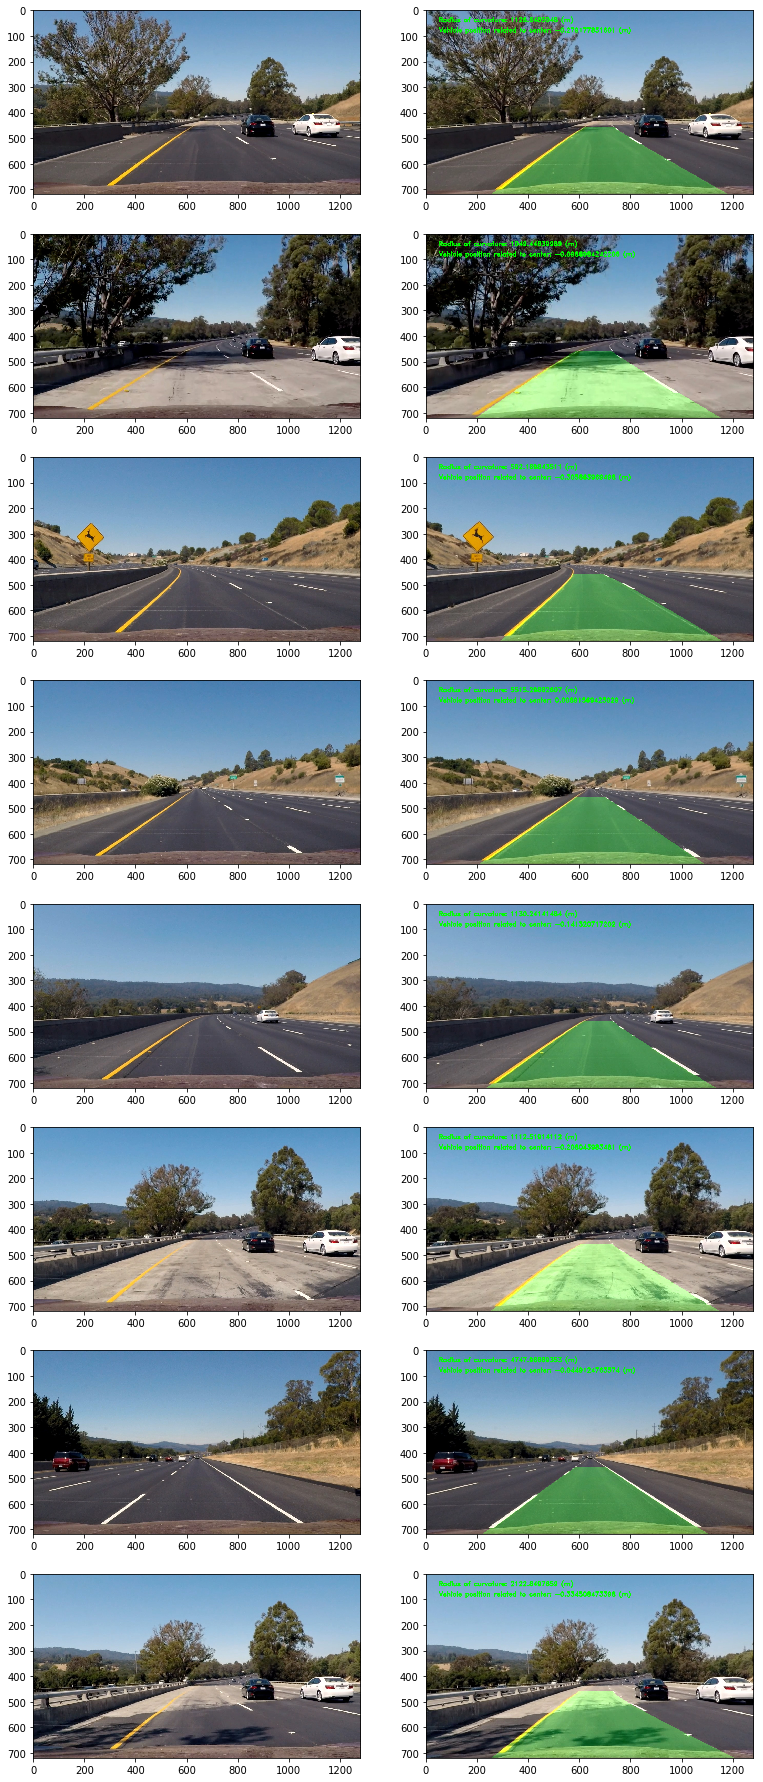

In [42]:
import os

# Make a list of images
images = glob.glob('test_images/*.jpg')
images_count = len(images)
fig, ax = plt.subplots(images_count, 2, figsize=(10, 27))



def process_img(img, dump_images, base = "", output_dir = ""):
    # Undistort
    undist = undistort(img)
    
    if dump_images:
        cv2.imwrite(output_dir + '/undist_' + base + '.jpg', undist)
    
    # Make binary
    bin_img, dbg_col_bin = make_binary(undist)
    if dump_images:
        #colored = np.dstack((bin_img, bin_img, bin_img)) * 255
        #cv2.cvtColor(col_bin, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_dir + '/bin_' + base + '.jpg', bin_img.astype('uint8') * 255)
    
    # Perspective transform
    (dbg, warped_bin_img) = perspective_transform(bin_img)
    if dump_images:
        cv2.imwrite(output_dir + '/warped_' + base + '.jpg', warped_bin_img.astype('uint8') * 255)
    
    # Find lanes and fit polynomial
    ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped_bin_img, NO_DBG)
    
    # Calculate the radius of curvature in pixels for both lane lines
    left_curverad, right_curverad, pos = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    result = draw_lane(undist, warped, left_fitx, right_fitx, ploty)
    result = draw_text(result, (left_curverad + right_curverad)/2, pos)
    
    return result


# Step through the list
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Get base name
    base = os.path.basename(fname)
    base = os.path.splitext(base)[0]
    
    result = process_img(img, DBG, base, 'output_images')
    
    # plot original and final image
    ax[idx, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[idx, 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)